# Strategia Contrarian Momentum Equi-Pesata sulle Commodities

Questo notebook implementa una strategia contrarian che è esattamente speculare alla momentum: ogni posizione è l'opposto della strategia momentum classica (dove la momentum va long, la contrarian va short e viceversa, senza filtri aggiuntivi).

**Logica della strategia:**

- Ogni venerdì: calcola il rendimento cumulativo degli ultimi N giorni per ogni commodity

- Seleziona le top N commodities con rendimento positivo più alto

- Dove la strategia momentum va long, questa va short (e viceversa)

- Applica i pesi dal LUNEDÌ successivo (elimina lookahead bias)


**Obiettivo:**

- Ottenere un grafico dell'equity perfettamente speculare rispetto alla strategia momentum

In [41]:
# Import e configurazione
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from core.commodity_momentum import generate_equal_weighted_commodity_momentum_signals, calculate_portfolio_performance

# Parametri strategia
lookback_days = 7
top_n = 3
rebalance_weekday = 4  # 0=lun, ..., 4=ven

In [ ]:
# Carica dati
df = pd.read_parquet('../data/commodities_extended_data.parquet')
commodities = sorted(set([c.split('_')[0] for c in df.columns if c.endswith('_Close')]))
print(f'Commodities disponibili ({len(commodities)}): {commodities}')

Commodities disponibili (26): ['COCOA', 'COFFEE', 'COPPER', 'CORN', 'COTTON', 'CRUDE', 'FEEDER', 'GASOLINE', 'GOLD', 'HEATING', 'LEAN', 'LIVE', 'LUMBER', 'NATGAS', 'OATS', 'ORANGE', 'PALLADIUM', 'PLATINUM', 'ROUGH', 'RUSSELL', 'SILVER', 'SOYBEANS', 'SOYMEAL', 'SOYOIL', 'SUGAR', 'WHEAT']


In [43]:
# Genera segnali contrarian: semplicemente l'opposto della strategia momentum
signals = -generate_equal_weighted_commodity_momentum_signals(
    df, lookback_days=lookback_days, top_n=top_n, rebalance_weekday=rebalance_weekday
)

In [44]:
# Calcola performance del portafoglio contrarian
equity = calculate_portfolio_performance(signals, df)

print(f'Performance dal {equity.index[0]} al {equity.index[-1]}:')
print(f'Rendimento totale: {(equity.iloc[-1] - 1) * 100:.2f}%')
print(f'Rendimento annualizzato: {((equity.iloc[-1] ** (252 / len(equity))) - 1) * 100:.2f}%')

Performance dal 2000-01-03 00:00:00-05:00 al 2025-08-04 00:00:00-04:00:
Rendimento totale: 64.80%
Rendimento annualizzato: 1.97%


In [45]:
# Statistiche di performance
returns = equity.pct_change().fillna(0)
print('=== STATISTICHE PERFORMANCE ===')
print(f'Rendimento totale: {(equity.iloc[-1] - 1) * 100:.2f}%')
print(f'Rendimento annualizzato: {((equity.iloc[-1] ** (252 / len(equity))) - 1) * 100:.2f}%')
print(f'Volatilità annua: {returns.std() * np.sqrt(252) * 100:.2f}%')
print(f'Sharpe Ratio: {(returns.mean() * 252) / (returns.std() * np.sqrt(252)):.2f}')
print(f'Max Drawdown: {((equity / equity.cummax()) - 1).min() * 100:.2f}%')

=== STATISTICHE PERFORMANCE ===
Rendimento totale: 64.80%
Rendimento annualizzato: 1.97%
Volatilità annua: 24.70%
Sharpe Ratio: 0.20
Max Drawdown: -77.33%


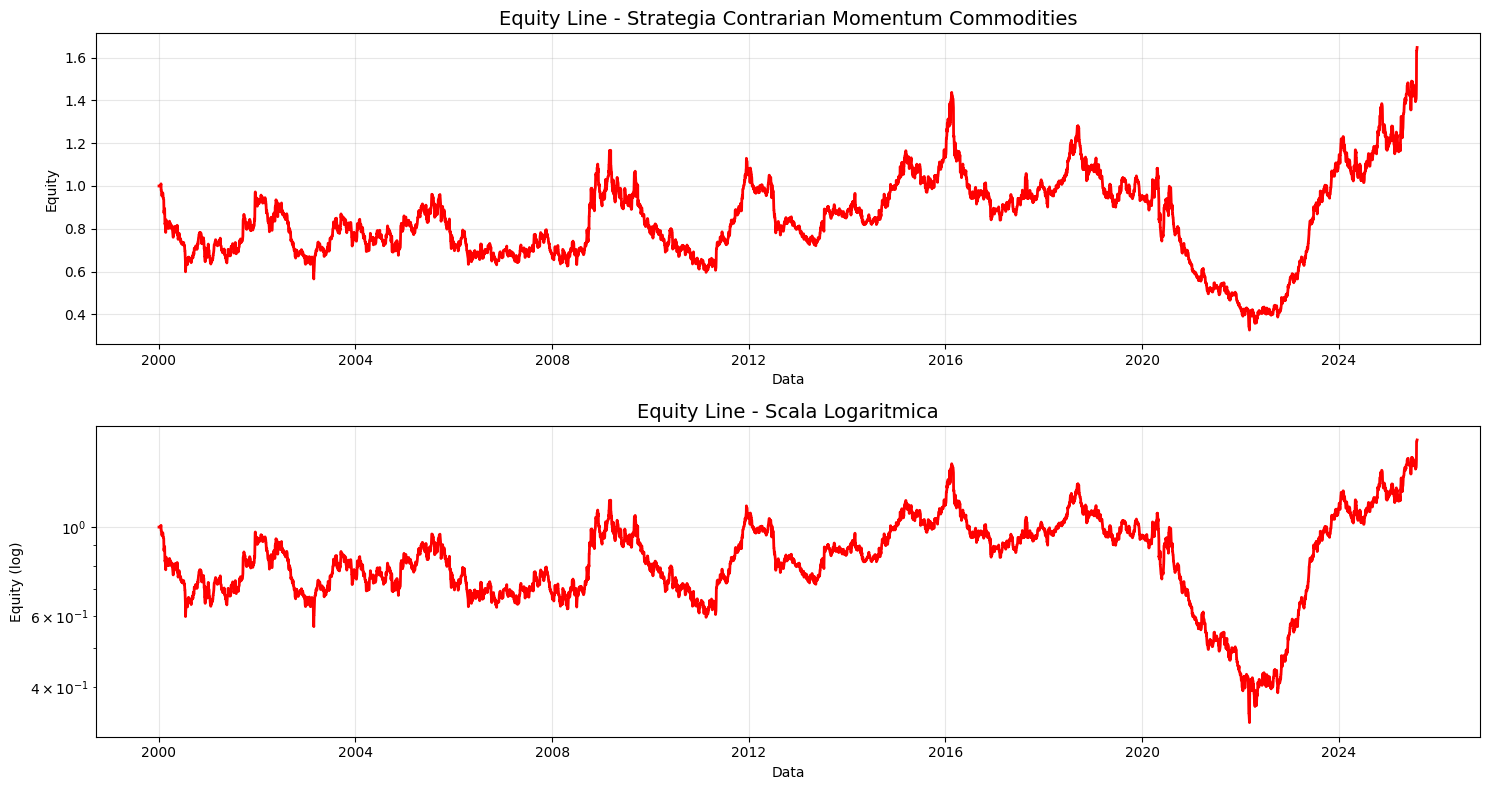

In [46]:
# Equity line
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
plt.plot(equity.index, equity.values, linewidth=2, color='red')
plt.title('Equity Line - Strategia Contrarian Momentum Commodities', fontsize=14)
plt.xlabel('Data')
plt.ylabel('Equity')
plt.grid(True, alpha=0.3)
plt.subplot(2, 1, 2)
plt.plot(equity.index, equity.values, linewidth=2, color='red')
plt.yscale('log')
plt.title('Equity Line - Scala Logaritmica', fontsize=14)
plt.xlabel('Data')
plt.ylabel('Equity (log)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

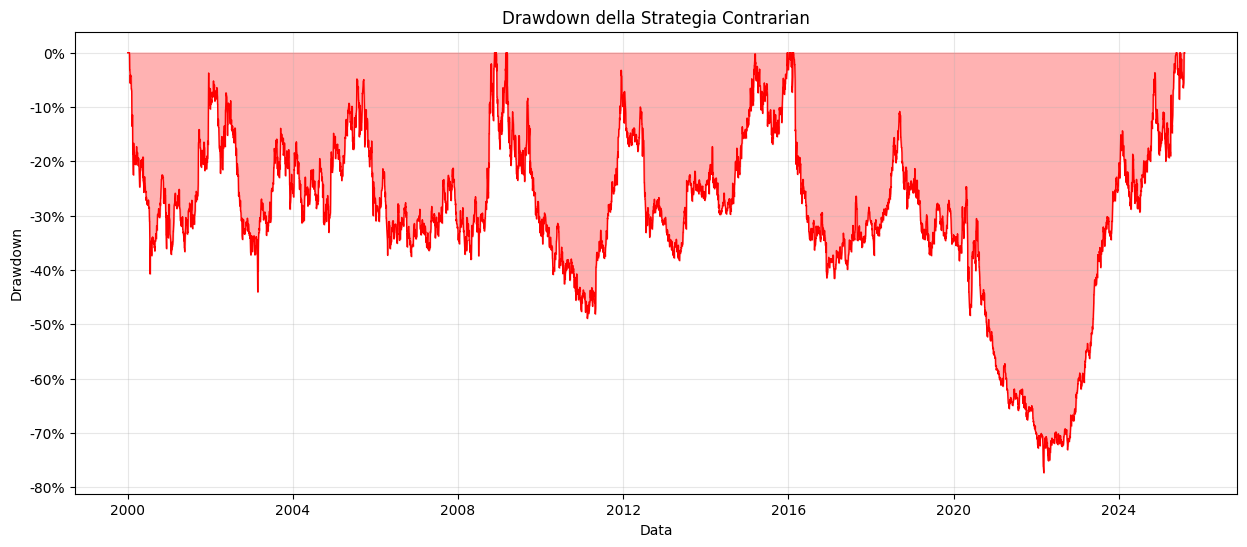

Top 5 Drawdown peggiori:
2022-03-08: -77.33%
2022-03-07: -76.90%
2022-03-03: -76.08%
2022-03-04: -76.08%
2022-04-18: -75.14%


In [47]:
# Analisi drawdown
running_max = equity.cummax()
drawdown = (equity / running_max) - 1
plt.figure(figsize=(15, 6))
plt.fill_between(drawdown.index, drawdown.values, 0, alpha=0.3, color='red')
plt.plot(drawdown.index, drawdown.values, color='red', linewidth=1)
plt.title('Drawdown della Strategia Contrarian')
plt.xlabel('Data')
plt.ylabel('Drawdown')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.grid(True, alpha=0.3)
plt.show()
worst_drawdowns = drawdown.nsmallest(5)
print('Top 5 Drawdown peggiori:')
for date, dd in worst_drawdowns.items():
    print(f'{date.strftime('%Y-%m-%d')}: {dd:.2%}')

## Riepilogo

- Questa strategia contrarian è ora esattamente speculare: ogni posizione è l'opposto della momentum classica.
- L'equity risultante deve essere perfettamente speculare rispetto alla strategia momentum (al netto di arrotondamenti numerici).
- Analizza le performance, la diversificazione e i drawdown come nel notebook originale.
- Confronta i risultati con la strategia momentum classica per verificare la specularità.

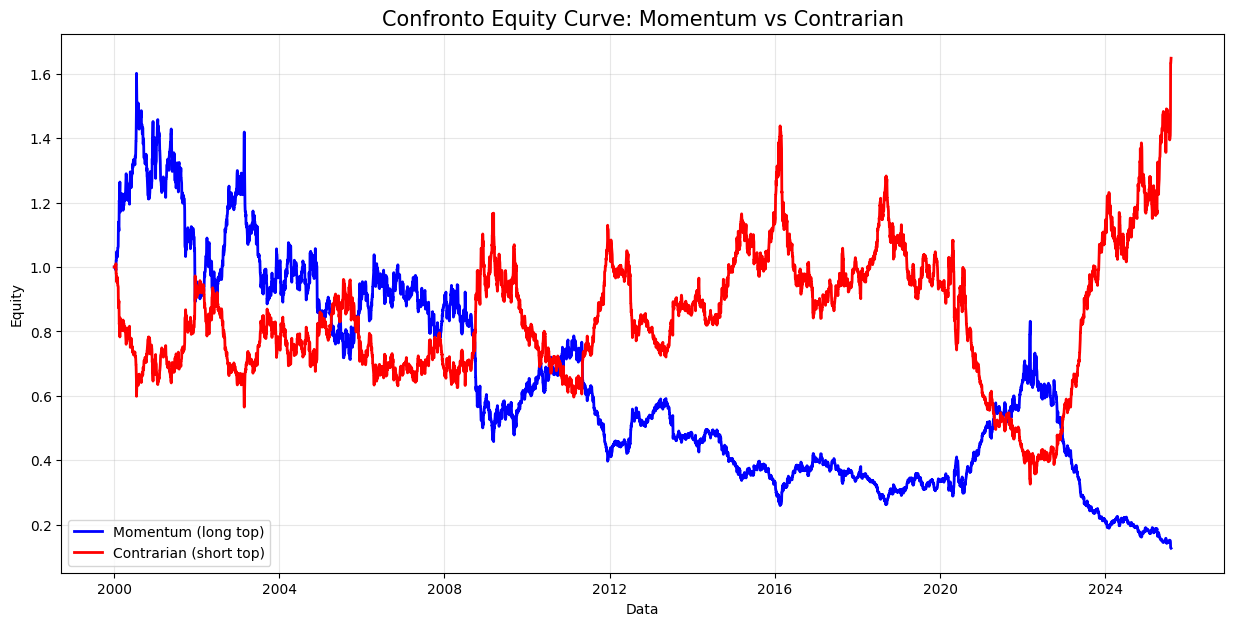

In [48]:
# Confronto visivo tra equity momentum e contrarian
import matplotlib.pyplot as plt
from core.commodity_momentum import generate_equal_weighted_commodity_momentum_signals, calculate_portfolio_performance

# Ricalcola equity momentum classica
signals_momentum = generate_equal_weighted_commodity_momentum_signals(
    df, lookback_days=lookback_days, top_n=top_n, rebalance_weekday=rebalance_weekday
)
equity_momentum = calculate_portfolio_performance(signals_momentum, df)

plt.figure(figsize=(15, 7))
plt.plot(equity_momentum.index, equity_momentum.values, label='Momentum (long top)', color='blue', linewidth=2)
plt.plot(equity.index, equity.values, label='Contrarian (short top)', color='red', linewidth=2)
plt.title('Confronto Equity Curve: Momentum vs Contrarian', fontsize=15)
plt.xlabel('Data')
plt.ylabel('Equity')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()